# Predictive Modeling: Vehicle Fuel Efficiency (MPG)

**Objective:** Build and compare models to predict Combined MPG using vehicle characteristics.

**Dataset:** `modeling_dataset.csv`  
**Target Variable:** Combined MPG (FT1)  
**Models Evaluated:** Linear Regression, k-Nearest Neighbors, Decision Tree

## **4. Setup and Data Loading**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("modeling_dataset.csv")

target = "Combined MPG (FT1)"
y = df[target].copy()
X = df.drop(columns=[target]).copy()

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=0)

## **4.1 Preprocessing Pipeline**

In [3]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

## **4.2 Model and Grid**

In [4]:
models = {
    "Linear Regression": LinearRegression(),
    
    "kNN": KNeighborsRegressor(),  
     
    "Decision Tree": DecisionTreeRegressor(random_state=0)  
}

param_grids = {
    "kNN": {"model__n_neighbors": [3, 5, 7, 9]},
    "Decision Tree": {"model__max_depth": [3, 5, 7, 10, None]},
    "Linear Regression": {}
}

## **4.3 5-Fold CV for Each Model**

In [5]:
cv_results = {}
best_models = {}  # Store the tuned models

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])
    #
    grid_search = GridSearchCV(
        pipe, 
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store the best model from tuning
    best_models[name] = grid_search.best_estimator_
    
    # Get R2 scores for the best model
    r2_scores = cross_val_score(
        grid_search.best_estimator_, 
        X_train, y_train,
        scoring="r2",
        cv=cv
    )
    
    cv_results[name] = {
        "RMSE Mean": -grid_search.best_score_,
        "RMSE Std": grid_search.cv_results_['std_test_score'][grid_search.best_index_],
        "R2 Mean": r2_scores.mean(),
        "R2 Std": r2_scores.std()
    }

cv_results_df = pd.DataFrame(cv_results).T
cv_results_df

,RMSE Mean,RMSE Std,R2 Mean,R2 Std
Linear Regression,1.704850,0.043864,0.887500,0.006694
kNN,1.388466,0.033484,0.925402,0.003966
Decision Tree,1.231169,0.029658,0.941346,0.003144


## **4.4 Final Model Fit + Test Set Evaluation**

In [6]:
# Pick the best model based on CV RMSE
best_model_name = cv_results_df["RMSE Mean"].idxmin()
best_model = best_models[best_model_name]
print("Best model from tuning:", best_model_name)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
test_rmse = mse ** 0.5                 
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²:   {test_r2:.4f}")

Best model from tuning: Decision Tree
Test RMSE: 1.1266
Test R²:   0.9512


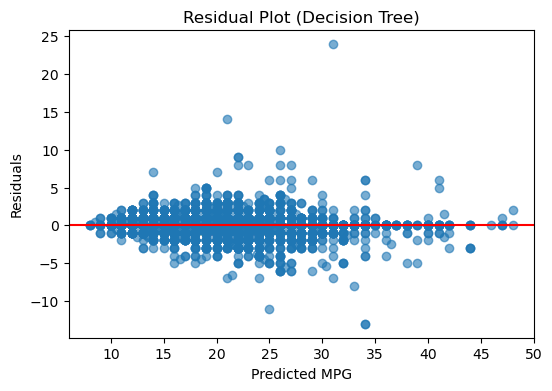

In [7]:
# residuals plot for best model
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals")
plt.title("Residual Plot (Decision Tree)")
plt.show()

## **4.5 Boxplot (CV RMSE)**

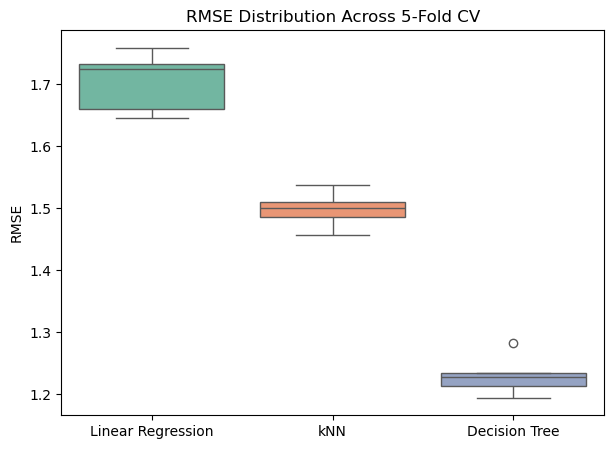

In [8]:
plt.figure(figsize=(7,5))
sns.boxplot(data=[-cross_val_score(
                    Pipeline([("preprocess", preprocess),
                              ("model", models[m])]),
                    X_train, y_train,
                    scoring="neg_root_mean_squared_error",
                    cv=cv)
                 for m in models],
            palette="Set2")

plt.xticks(ticks=range(len(models)), labels=list(models.keys()))
plt.title("RMSE Distribution Across 5-Fold CV")
plt.ylabel("RMSE")
plt.show()